In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score,mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
import holidays
from datetime import timedelta

In [2]:
# Load and Optimize Datasets
def optimize_memory(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].astype('float32')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = df[col].astype('int32')
    return df
uber_2014 = optimize_memory(pd.read_csv("uber-raw-data-aprsep-14.csv"))
uber_2015 = optimize_memory(pd.read_csv("uber-raw-data-janjune-15.csv"))

uber_2014['Date/Time'] = pd.to_datetime(uber_2014['Date/Time'])
uber_2015['Pickup_date'] = pd.to_datetime(uber_2015['Pickup_date'])
uber_2015.rename(columns={'Pickup_date': 'Date/Time'}, inplace=True)
# Merge datasets
uber_data = pd.concat([uber_2014, uber_2015], ignore_index=True)
uber_data.set_index('Date/Time', inplace=True)
uber_data.to_csv("uber_2014_2015.csv", index=False)

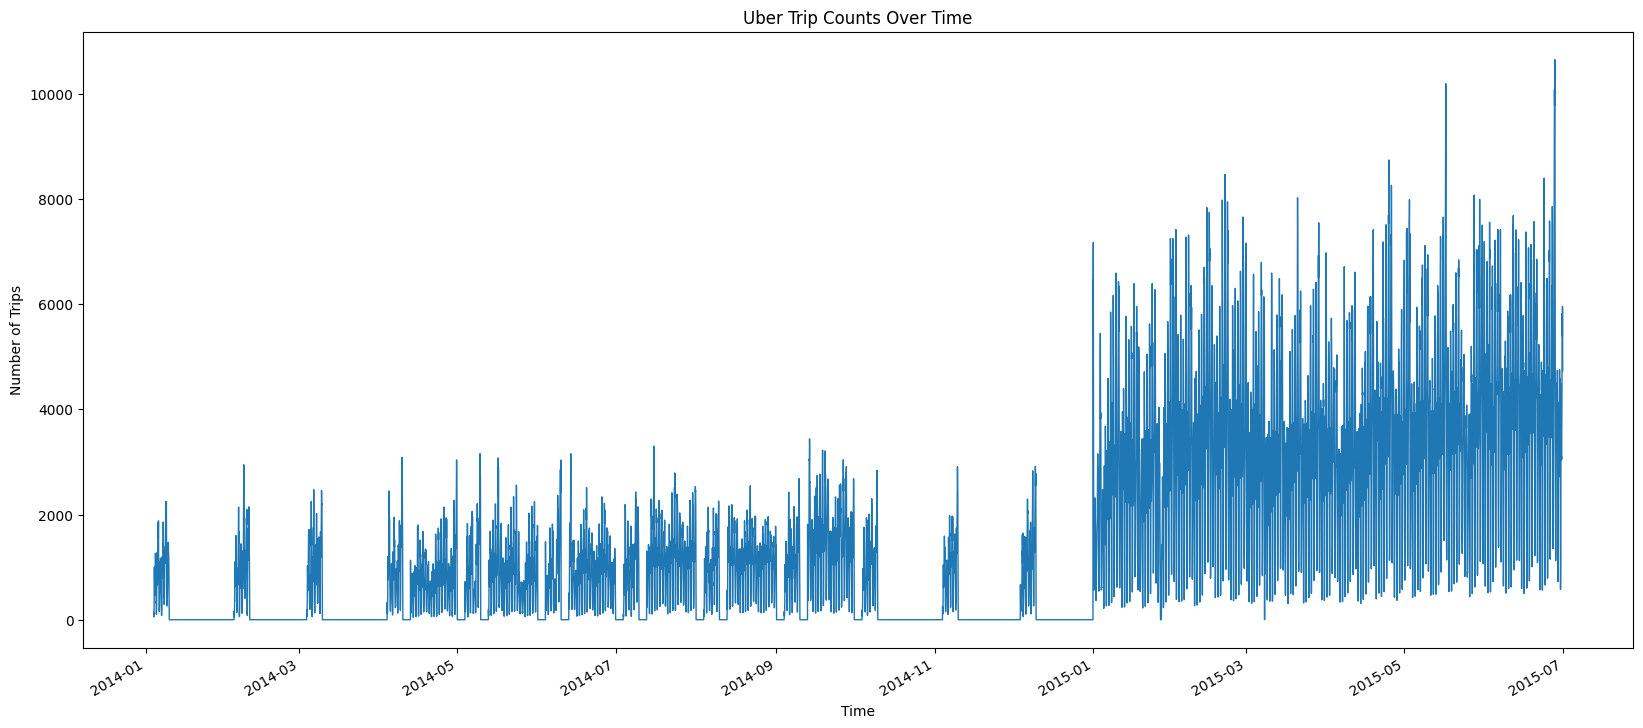

In [3]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(20, 8))
plt.plot(uber_data.resample('h').size(), linewidth=1)
plt.title("Uber Trip Counts Over Time")
plt.ylabel('Number of Trips')
plt.xlabel('Time')
plt.xticks(rotation=30, ha='right')
plt.show()

In [4]:
# Feature Engineering
def feature_engineering(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9) | (df['hour'] >= 16) & (df['hour'] <= 19)).astype(int)   
    # Holidays
    ny_holidays = holidays.US(years=[2014, 2015])
    df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in ny_holidays else 0)  
    # Lag Features
    df['lag_1h'] = df['trip_count'].shift(1)
    df['lag_24h'] = df['trip_count'].shift(24)   
    # Moving Averages
    df['moving_avg_3h'] = df['trip_count'].rolling(window=3).mean()
    df['moving_avg_6h'] = df['trip_count'].rolling(window=6).mean()  
    return df
trip_counts = uber_data.resample('h').size().to_frame(name='trip_count')
trip_counts = feature_engineering(trip_counts).dropna()

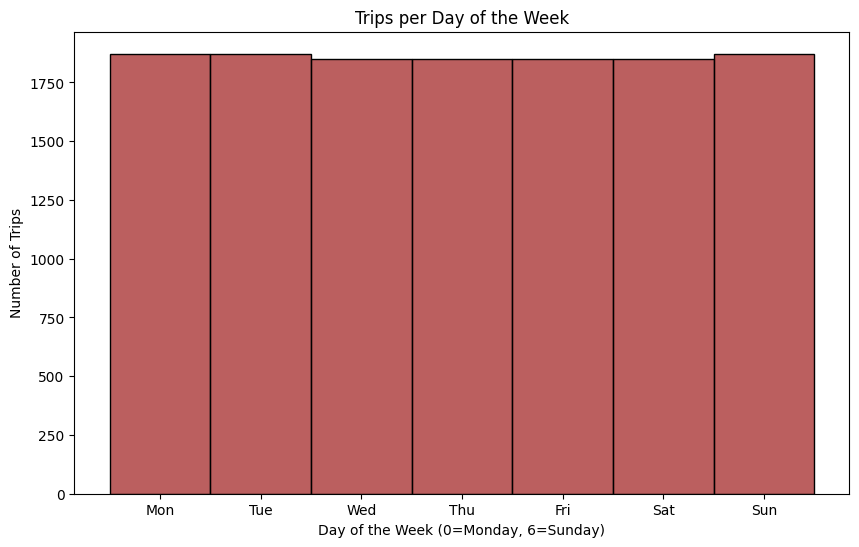

In [5]:
# Visualizing Data Distributions
plt.figure(figsize=(10, 6))
sns.histplot(x=trip_counts.index.dayofweek, bins=7, discrete=True, color='brown')
plt.title('Trips per Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Trips')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

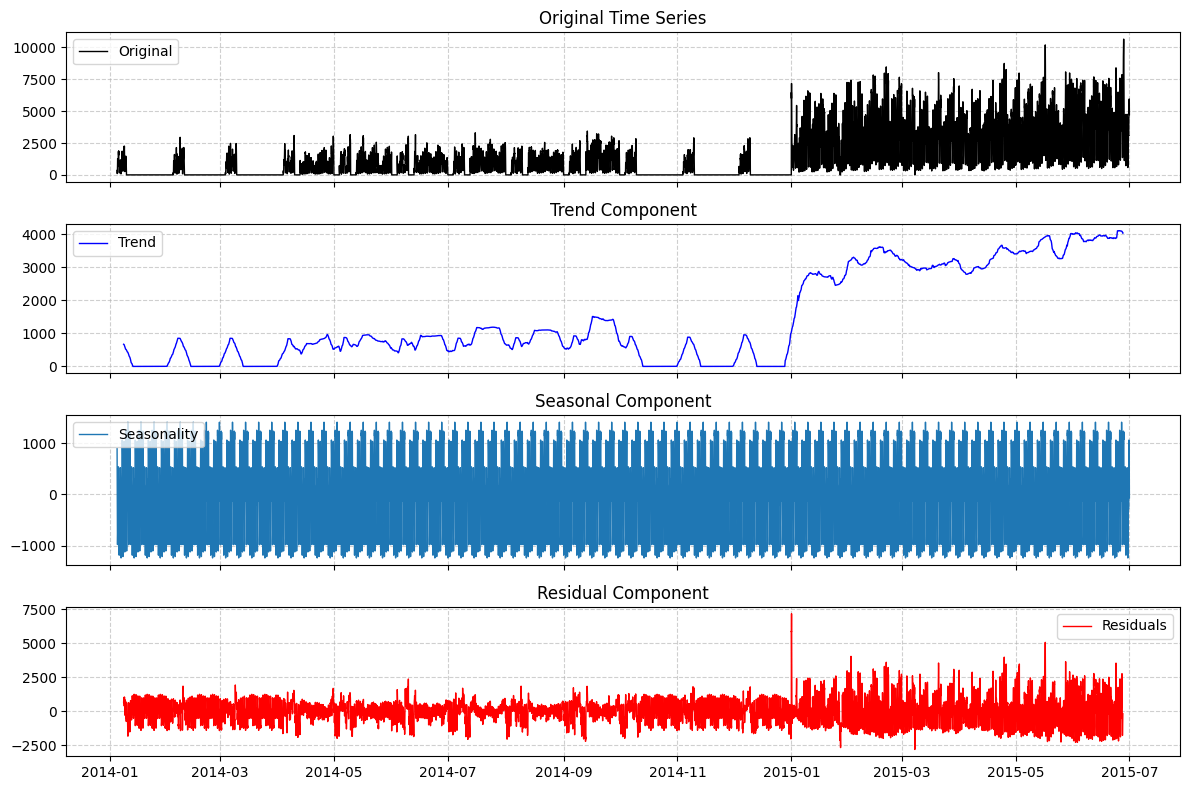

In [6]:
# Time-Series Decomposition
result = seasonal_decompose(trip_counts['trip_count'], model='additive', period=168)
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axes[0].plot(trip_counts['trip_count'], label="Original", color='black', linewidth=1)
axes[0].set_title("Original Time Series")

axes[1].plot(result.trend, label="Trend", color='blue', linewidth=1)
axes[1].set_title("Trend Component")

axes[2].plot(result.seasonal, label="Seasonality", linewidth=1)
axes[2].set_title("Seasonal Component")

axes[3].plot(result.resid, label="Residuals", color='red', linewidth=1)
axes[3].set_title("Residual Component")

for ax in axes:
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

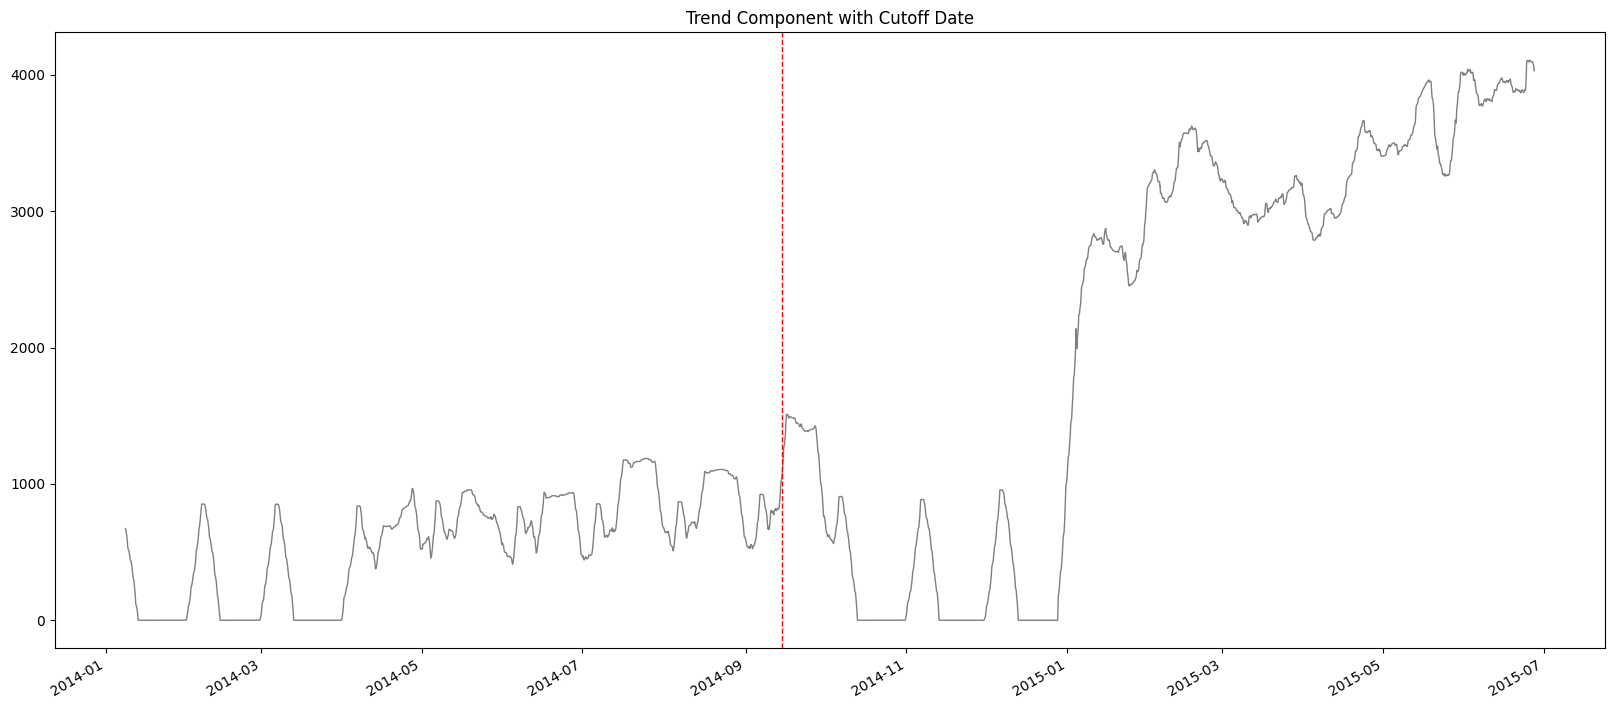

In [7]:
# Trend Analysis with Cutoff Date
cutoff_date = '2014-09-15 00:00:00'
plt.figure(figsize=(20, 8))
plt.plot(result.trend, linewidth=1, color='gray')
plt.axvline(x=pd.Timestamp(cutoff_date), color='red', linestyle='--', linewidth=1)
plt.title("Trend Component with Cutoff Date")
plt.xticks(rotation=30, ha='right')
plt.show()

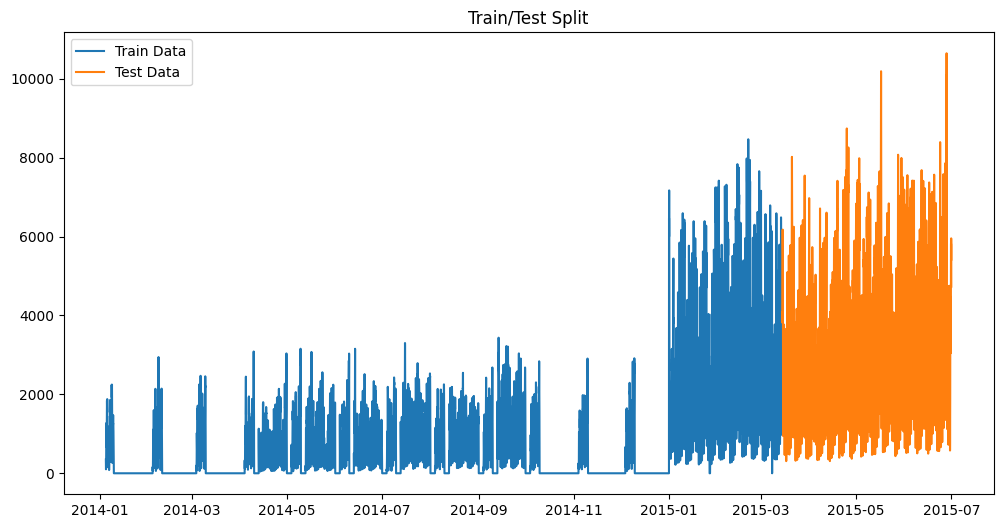

In [8]:
# Train-Test Split for Time-Series Data
ts_split = TimeSeriesSplit(n_splits=5)
train_size = int(len(trip_counts) * 0.8)
train, test = trip_counts.iloc[:train_size], trip_counts.iloc[train_size:]
X_train, y_train = train.drop(columns=['trip_count']), train['trip_count']
X_test, y_test = test.drop(columns=['trip_count']), test['trip_count']

plt.figure(figsize=(12, 6))
plt.plot(train.index, y_train, label="Train Data")
plt.plot(test.index, y_test, label="Test Data")
plt.title("Train/Test Split")
plt.legend()
plt.show()

In [9]:
# Hyperparameter Tuning
grid_params = {
    'n_estimators': [100, 300, 500], 
    'max_depth': [3, 6, 9], 
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb_grid = GridSearchCV(
    XGBRegressor(objective='reg:squarederror', tree_method='hist'),
    param_grid=grid_params, 
    cv=TimeSeriesSplit(n_splits=5), 
    scoring='r2'
)
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 300, 500]},
             scoring='r2')

In [10]:
# Train Models
xgb_model = xgb_grid.best_estimator_
gbtr_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=6)
rf_model = RandomForestRegressor(n_estimators=300, max_depth=6, random_state=42)
gbtr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=300, random_state=42)

In [11]:
# Generate Predictions
xgb_pred = xgb_model.predict(X_test)
gbtr_pred = gbtr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
ensemble_pred = (xgb_pred + gbtr_pred + rf_pred) / 3

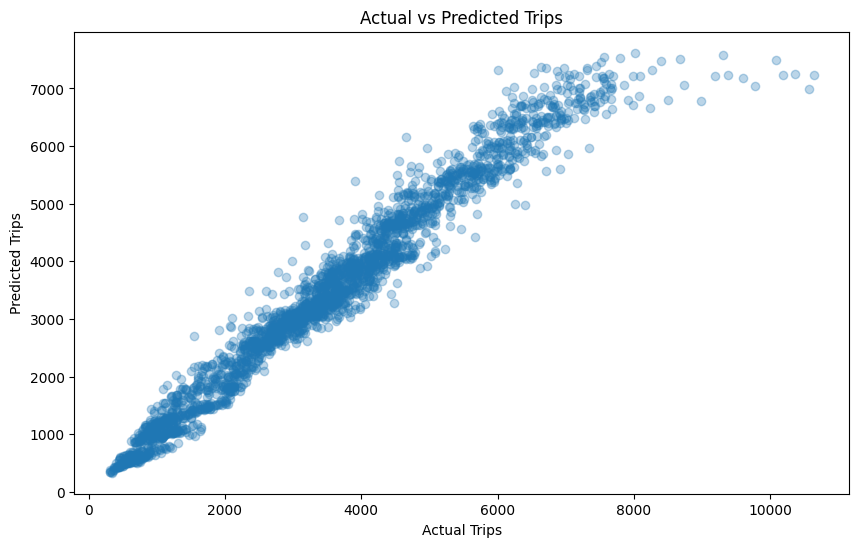

In [12]:
# Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ensemble_pred, alpha=0.3)
plt.xlabel('Actual Trips')
plt.ylabel('Predicted Trips')
plt.title('Actual vs Predicted Trips')
plt.show()

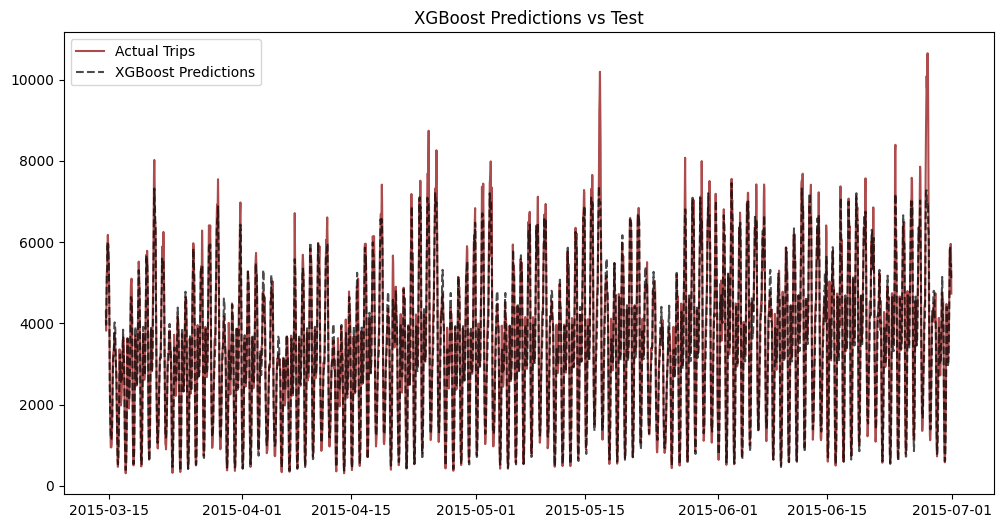

In [13]:
# XGBoost Predictions vs Test
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Trips", alpha=0.7, color="darkred")
plt.plot(y_test.index, xgb_pred, label="XGBoost Predictions", alpha=0.7, linestyle='dashed', color="black")
plt.legend()
plt.title("XGBoost Predictions vs Test")
plt.show()

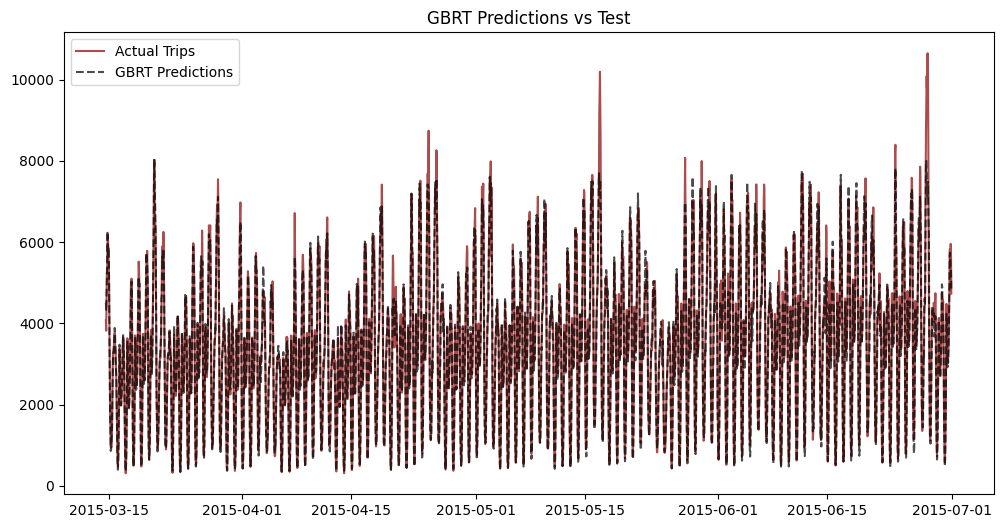

In [14]:
# Plot GBRT Predictions vs Test
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Trips", alpha=0.7, color="darkred")
plt.plot(y_test.index, gbtr_pred, label="GBRT Predictions", alpha=0.7, linestyle='dashed', color="black")
plt.legend()
plt.title("GBRT Predictions vs Test")
plt.show()

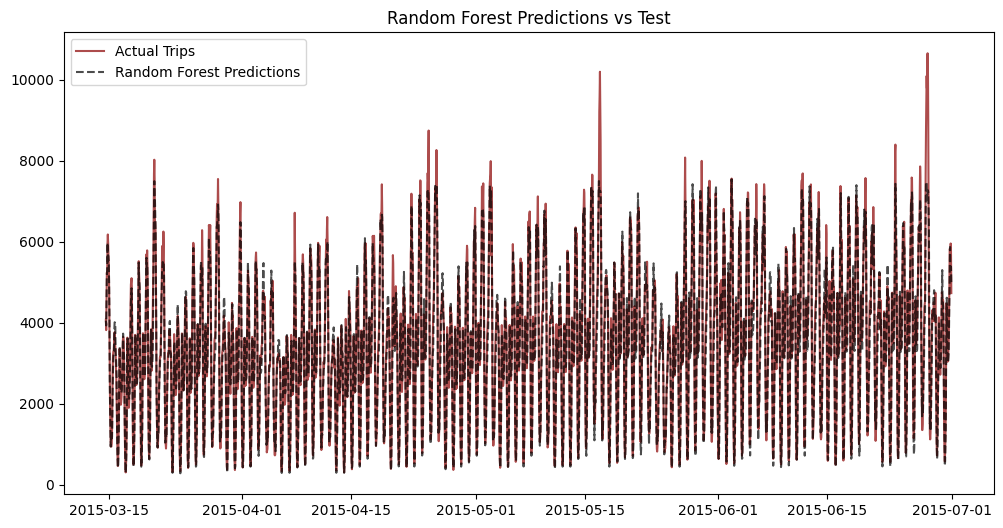

In [15]:
# Random Forest Predictions vs Test
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Trips", alpha=0.7, color="darkred")
plt.plot(y_test.index, rf_pred, label="Random Forest Predictions", alpha=0.7, linestyle='dashed', color="black")
plt.legend()
plt.title("Random Forest Predictions vs Test")
plt.show()

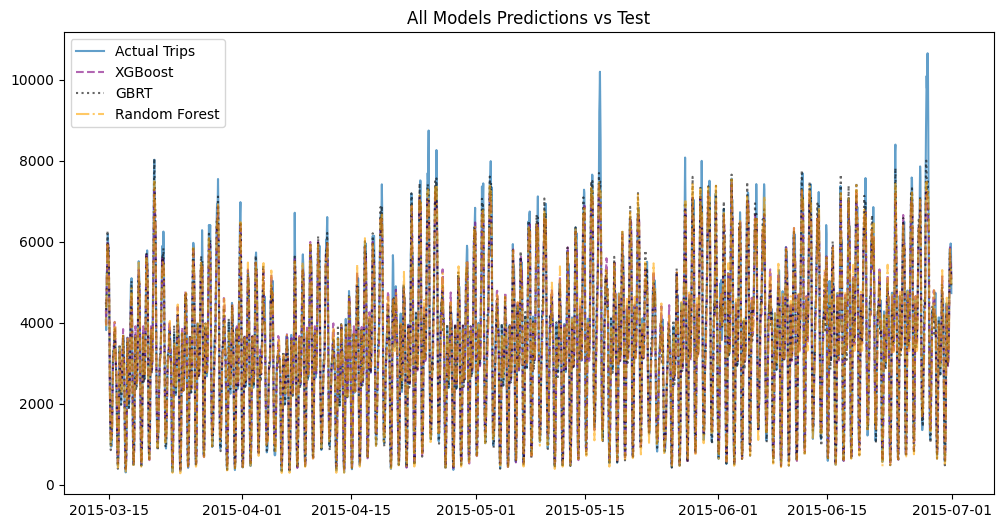

In [16]:
# All Models Predictions vs Test
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Trips", alpha=0.7)
plt.plot(y_test.index, xgb_pred, label="XGBoost", alpha=0.6, linestyle='dashed', color="purple")
plt.plot(y_test.index, gbtr_pred, label="GBRT", alpha=0.6, linestyle='dotted', color="black")
plt.plot(y_test.index, rf_pred, label="Random Forest", alpha=0.6, linestyle='dashdot', color="orange")
plt.legend()
plt.title("All Models Predictions vs Test")
plt.show()

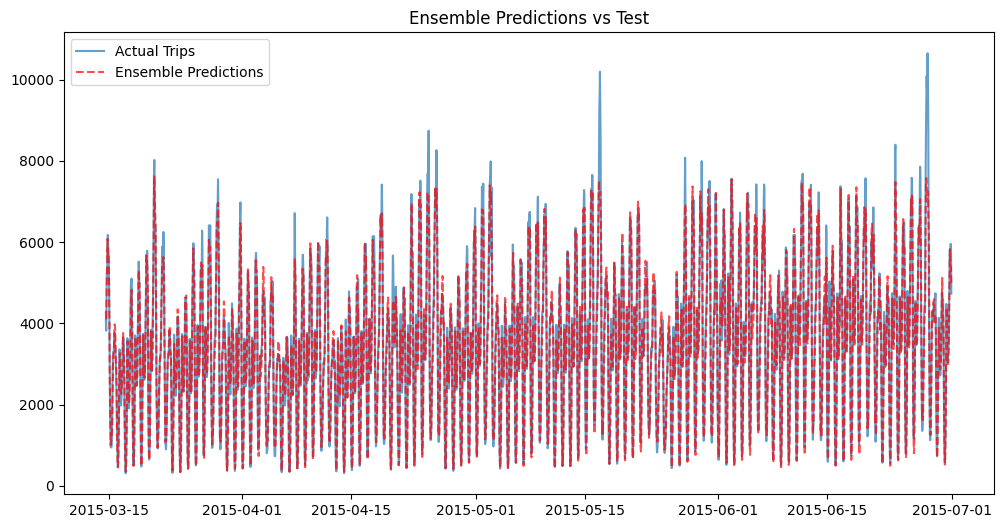

In [17]:
# Ensemble Predictions vs Test
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Trips", alpha=0.7)
plt.plot(y_test.index, ensemble_pred, label="Ensemble Predictions", alpha=0.7, linestyle='dashed', color="red")
plt.legend()
plt.title("Ensemble Predictions vs Test")
plt.show()

In [18]:
# Weighted Ensemble Model
r2_scores = {
    'XGBoost': r2_score(y_test, xgb_pred),
    'GBTR': r2_score(y_test, gbtr_pred),
    'Random Forest': r2_score(y_test, rf_pred)
}

total_r2 = sum(r2_scores.values())
weights = {model: r2 / total_r2 for model, r2 in r2_scores.items()}

# Weighted Ensemble Prediction
ensemble_pred = (
    weights['XGBoost'] * xgb_pred +
    weights['GBTR'] * gbtr_pred +
    weights['Random Forest'] * rf_pred
)

In [19]:
# Model Evaluation
def evaluate(y_true, y_pred):
    return {
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'Adj R2': 1 - (1 - r2_score(y_true, y_pred)) * (len(y_true) - 1) / (len(y_true) - X_train.shape[1] - 1)
    }
eval_results = {
    'XGBoost': evaluate(y_test, xgb_pred),
    'GBTR': evaluate(y_test, gbtr_pred),
    'Random Forest': evaluate(y_test, rf_pred),
    'Ensemble': evaluate(y_test, ensemble_pred)
}
eval_results_df = pd.DataFrame(eval_results).T
print(eval_results_df)

                   MAPE        RMSE        R2         MAE    Adj R2
XGBoost        0.107896  427.999288  0.945281  304.096283  0.945049
GBTR           0.063947  316.844436  0.970012  196.586372  0.969885
Random Forest  0.105755  417.440921  0.947948  298.401794  0.947727
Ensemble       0.084414  362.169357  0.960819  244.804651  0.960653
